# Information

* **Reference: [Unet Pytorch Baseline (LB 0.608) - Submission](https://www.kaggle.com/code/janhuebi/unet-pytorch-baseline-lb-0-608-submission)**

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import numpy as np
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
!pip install -q torchsummary
from torchvision import models
from torchsummary import summary

# Get the Device

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

# Config File

In [3]:
class CFG:
    
    # Path to the data folder (Thanks to @Kenni)
    GLOBAL_PATH = '/kaggle/input/google-research-identify-contrails-preprocessing'
    
    # base image size
    resize_value = 256
    
    # resize image
    resize = False
    if resize:
        resize_value = 384
        
    # Model Settings    
    model = 'UNET'
    encoder = 'timm-resnest26d'
    weights = 'imagenet'
    
    batch_size = 16
    optimizer='Adam'
    lr = 5e-4
    epochs = 40

# Create the Torch Dataset

In [4]:
#A custom Dataset class must implement three functions: __init__, __len__, and __getitem__
class ContrailDataset(Dataset):
    
    def __init__(self, base_dir, data_type='train'):
        assert data_type in ['train_images', 'validate_images'], \
            "'data_type' should be one of 'train_images' or 'validate_images'"
        
        self.base_dir = base_dir
        self.data_type = data_type
        self.record = os.listdir(self.base_dir +'/'+ self.data_type)
       
        self.resize_image = T.Resize(CFG.resize_value,interpolation=T.InterpolationMode.BILINEAR,antialias=True)
        self.resize_mask = T.Resize(CFG.resize_value,interpolation=T.InterpolationMode.NEAREST,antialias=True)
   
    def __len__(self):
        return len(self.record)

    def __getitem__(self, idx):
        
        record_id = self.record[idx]
        record_dir = os.path.join(self.base_dir, self.data_type, record_id)
        
        false_color = np.load(os.path.join(record_dir,'image.npy'))
        human_pixel_mask = np.load(os.path.join(record_dir,'human_pixel_masks.npy')) 
        
        false_color = torch.from_numpy(false_color)#.clone().detach()
        human_pixel_mask = torch.from_numpy(human_pixel_mask)#.clone().detach()
        
        false_color = torch.moveaxis(false_color,-1,0)
        human_pixel_mask = torch.moveaxis(human_pixel_mask,-1,0)
            
        if self.data_type == 'train':
            
            random_crop_factor = torch.rand(1)
            crop_min, crop_max = 0.5 , 1
            crop_factor = crop_min + random_crop_factor * (crop_max-crop_min) 
            crop_size = int(crop_factor * 256)
            self.crop = T.CenterCrop(size=crop_size)
            
            false_color = self.crop(false_color)
            human_pixel_mask =  self.crop(human_pixel_mask)
            
            false_color = self.resize_image(false_color)
            human_pixel_mask =  self.resize_mask(human_pixel_mask)

        
        #if CFG.resize and self.data_type=='validation':
            #false_color = self.resize_image(false_color)
            #human_pixel_mask =  self.resize_mask(human_pixel_mask)
                  
        # false color is scaled between 0 and 1!
        return false_color, human_pixel_mask.float()


# Create the Training and Validation Dataloader

In [5]:
training_data = ContrailDataset(base_dir=CFG.GLOBAL_PATH, data_type='train_images')
train_dataloader = DataLoader(
    training_data, 
    batch_size=CFG.batch_size, 
    shuffle=True, 
    num_workers= 4 if torch.cuda.is_available() else 0,
    pin_memory=True,
    drop_last = True
)

validation_data = ContrailDataset(base_dir=CFG.GLOBAL_PATH, data_type='validate_images')
validation_dataloader = DataLoader(
    validation_data, 
    batch_size=CFG.batch_size, 
    shuffle=False, 
    num_workers= 4 if torch.cuda.is_available() else 0,
    pin_memory=True,
    drop_last = True
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Show some Images from the Dataloaders

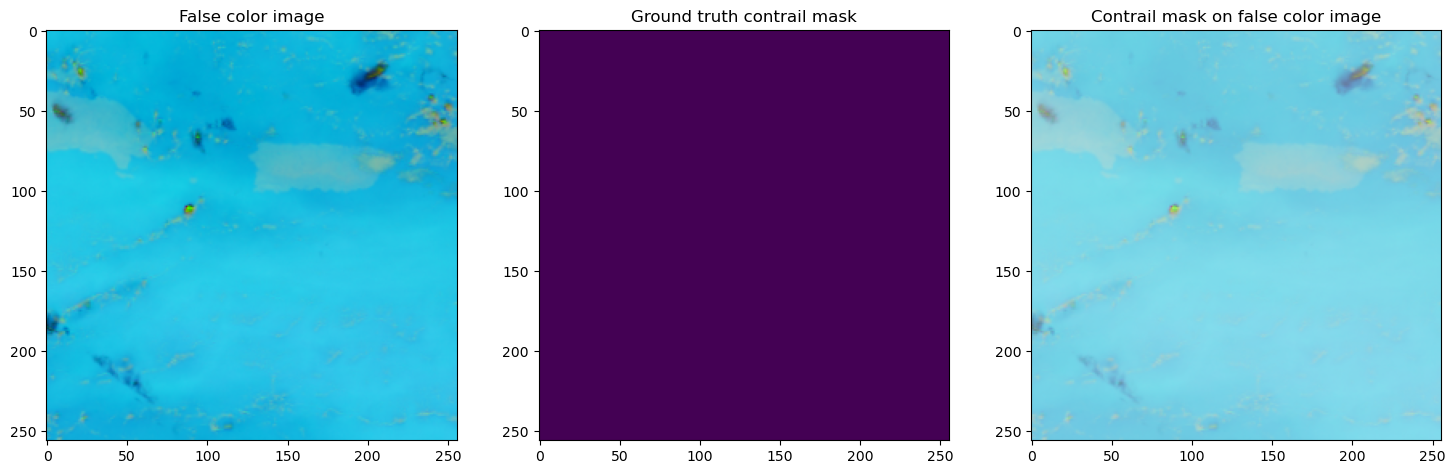

In [6]:
image,mask = next(iter(validation_dataloader))

image = torch.moveaxis(image,1,-1)
mask = torch.moveaxis(mask,1,-1)

for i in range(1):

    plt.figure(figsize=(18, 6))
    
    ax = plt.subplot(1, 3, 1)
    ax.imshow(image[i])
    ax.set_title('False color image')
    

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask[i], interpolation='none')
    ax.set_title('Ground truth contrail mask')
        
    ax = plt.subplot(1, 3, 3)
    ax.imshow(image[i])
    ax.imshow(mask[i], cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

# Create the Model UNET

In [7]:
if CFG.model == 'UNET':
    model = smp.Unet(
    encoder_name =CFG.encoder,
    encoder_weights=CFG.weights,    # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,        # model output channels (number of classes in your dataset)
    activation="sigmoid",
    )
    model.to(device)
    summary(model, (3, 256, 256))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth
100%|██████████| 65.3M/65.3M [00:03<00:00, 19.3MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,216
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,432
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]           4,096
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,

# Optimizer

In [8]:
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience = 4, factor = 0.31622776601, verbose = True)
print(f'learning rate: {optimizer.param_groups[0]["lr"]}')

learning rate: 0.0005


# Loss Function

In [9]:
# Average dice score for the examples in a batch
def dice_avg(y_p, y_t,smooth=1e-3):
    i = torch.sum(y_p * y_t, dim=(2, 3))
    u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(2, 3))
    score = (2 * i + smooth)/(u + smooth)
    return torch.mean(score)


def dice_loss_avg(y_p,y_t):
    return 1-dice_score_jan(y_p,y_t)

In [10]:
def dice_global(y_p,y_t,smooth=1e-3):

    intersection = torch.sum(y_p * y_t)
    union = torch.sum(y_p) + torch.sum(y_t)

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

def dice_loss_global(y_p,y_t):
    return 1-dice_global(y_p,y_t)

# Training and Validation Loop

In [11]:
train_dice_global = []
train_dice_avg = []
eval_dice_global = []
eval_dice_avg = []
bst_dice = 0
bst_epoch = 1
for epoch in range(1,CFG.epochs+1):
    
    print(f'________epoch: {epoch}________')
    
    # Early stopping
    if epoch-bst_epoch >=10:
        print(f'early stopping in epoch {epoch}')
        break
    
    model.train()
    bar = tqdm(train_dataloader)
    tot_loss_global = 0
    tot_dice_global = 0
    tot_dice_avg = 0
    count = 0
    for image, mask in bar:
        
        image = torch.nn.functional.interpolate(image, 
                                                size=CFG.resize_value,
                                                mode='bilinear'
                                               )
        
        # Transfer to Device
        image,mask = image.to(device), mask.to(device)
        
        # Set optimizer gradients to zero
        optimizer.zero_grad()
        
        #Perform Inference
        pred_mask = model(image)
        
        # If the image was resized, use a resizing step to make 256 again
        if CFG.resize:
            pred_mask = torch.nn.functional.interpolate(pred_mask, 
                                                        size=256,
                                                        mode='bilinear'
                                                       )
        
        # Calculate the loss and do a backward pass
        loss = dice_loss_global(pred_mask, mask)
        loss.backward()
        
        # Adjust the weights
        optimizer.step()

        tot_loss_global += loss.item()
        tot_dice_global+=1-loss.item()
        tot_dice_avg += dice_avg(pred_mask,mask).item()
        count += 1
        bar.set_postfix(TrainDiceLossGlobal=f'{tot_loss_global/count:.4f}', 
                        TrainDiceGlobal=f'{tot_dice_global/count:.4f}',
                        TrainDiceAvg = f'{tot_dice_avg/count:.4f}')
        
    train_dice_global.append(np.array(tot_dice_global/count))
    train_dice_avg.append(np.array(tot_dice_avg/count))
      
    model.train(False)
    bar = tqdm(validation_dataloader)
    tot_dice_global = 0
    tot_dice_avg = 0
    count = 0
    for image, mask in bar:
        
        if CFG.resize:
            image = torch.nn.functional.interpolate(image, 
                                                size=CFG.resize_value,
                                                mode='bilinear'
                                               )
        image,mask = image.to(device), mask.to(device)
        pred_mask = model(image)
        
        if CFG.resize:
            pred_mask = torch.nn.functional.interpolate(pred_mask, 
                                                size=256,
                                                mode='bilinear'
                                               )
        
        tot_dice_global += dice_global(pred_mask, mask).item()
        tot_dice_avg+=dice_avg(pred_mask,mask).item()
        count += 1
        bar.set_postfix(ValidDiceGlobal=f'{tot_dice_global/count:.4f}',
                        ValidDiceAvg = f'{tot_dice_avg/count:.4f}')
        

    eval_dice_global.append(np.array(tot_dice_global/count))
    eval_dice_avg.append(np.array(tot_dice_avg/count))
    scheduler.step(1-(tot_dice_global/count))
    print(f'learning rate: {optimizer.param_groups[0]["lr"]}')
        
    if tot_dice_global/count > bst_dice:
        bst_dice = tot_dice_global/count
        bst_epoch = epoch
        torch.save(model.state_dict(), f'model_state_dict_epoch_{epoch}_dice_{bst_dice:.4f}.pth')
        torch.save(model, f'model_epoch_{epoch}_dice_{bst_dice:.4f}.pt')
        print(f"current model saved! Epoch: {epoch} global dice: {bst_dice} avg dice: {tot_dice_avg/count}") 
        
 

________epoch: 1________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 1 global dice: 0.5012125458130774 avg dice: 0.1250749812401221
________epoch: 2________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 3________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 3 global dice: 0.5414774283961904 avg dice: 0.15284502400278016
________epoch: 4________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 5________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 6________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 6 global dice: 0.5487822514568181 avg dice: 0.28413153555372667
________epoch: 7________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 7 global dice: 0.5553802186228233 avg dice: 0.41399517115847817
________epoch: 8________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 8 global dice: 0.5566083323694392 avg dice: 0.3481737499863937
________epoch: 9________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 10________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 10 global dice: 0.5627049386692792 avg dice: 0.49735008257216423
________epoch: 11________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 12________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 13________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 14________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 14 global dice: 0.5661031727936598 avg dice: 0.6499337135203953
________epoch: 15________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 15 global dice: 0.5781718099325927 avg dice: 0.6186508731595401
________epoch: 16________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 17________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 18________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 18 global dice: 0.5814706776169232 avg dice: 0.7245623954925043
________epoch: 19________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 20________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 20 global dice: 0.5842979577562503 avg dice: 0.656262921105171
________epoch: 21________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 22________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 23________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 24________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 25________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 1.5811e-04.
learning rate: 0.00015811388300500002
________epoch: 26________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.00015811388300500002
current model saved! Epoch: 26 global dice: 0.5903247309438797 avg dice: 0.722490419601572
________epoch: 27________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.00015811388300500002
current model saved! Epoch: 27 global dice: 0.5932880643343251 avg dice: 0.7000223583188551
________epoch: 28________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.00015811388300500002
________epoch: 29________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.00015811388300500002
________epoch: 30________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.00015811388300500002
________epoch: 31________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.00015811388300500002
________epoch: 32________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

Epoch 00032: reducing learning rate of group 0 to 5.0000e-05.
learning rate: 4.999999999783766e-05
________epoch: 33________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 4.999999999783766e-05
________epoch: 34________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 4.999999999783766e-05
________epoch: 35________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 4.999999999783766e-05
________epoch: 36________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 4.999999999783766e-05
________epoch: 37________
early stopping in epoch 37


# Training and Validation History

<function matplotlib.pyplot.show(close=None, block=None)>

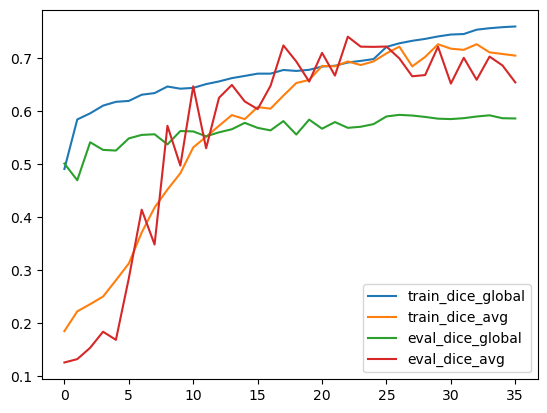

In [12]:
plt.plot(train_dice_global, label='train_dice_global')
plt.plot(train_dice_avg,label='train_dice_avg')
plt.plot(eval_dice_global, label='eval_dice_global')
plt.plot(eval_dice_avg,label='eval_dice_avg')
plt.legend()
plt.show

# Show some predictions for the validation dataset

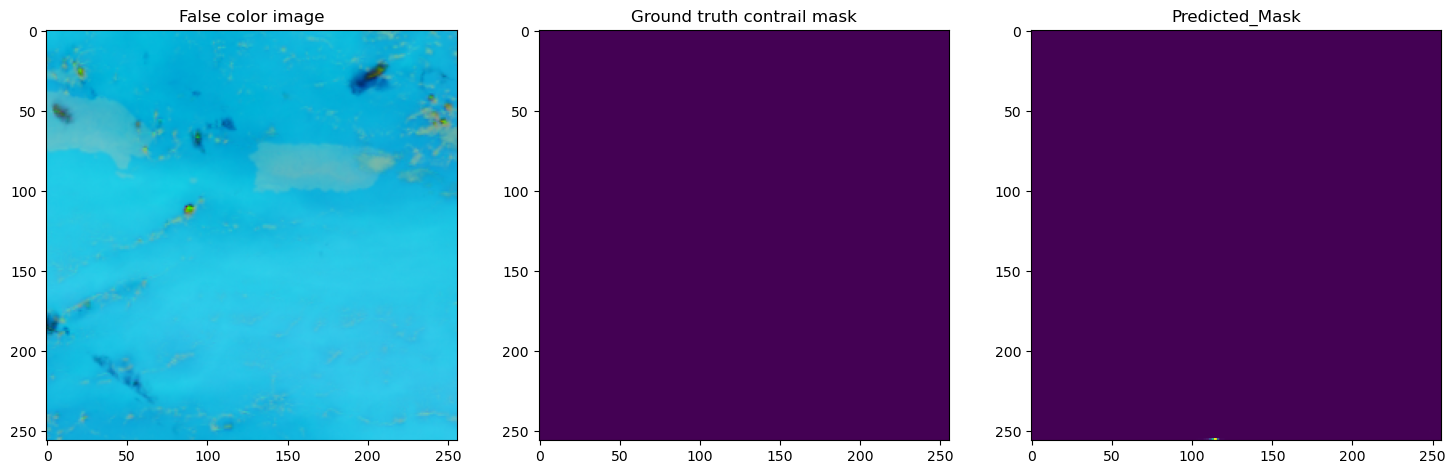

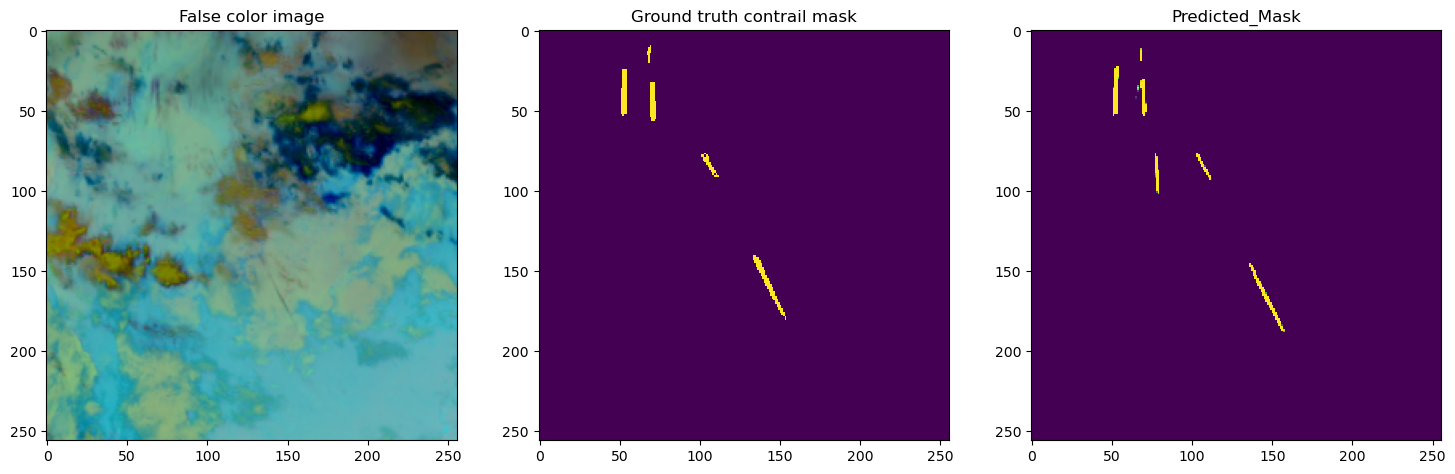

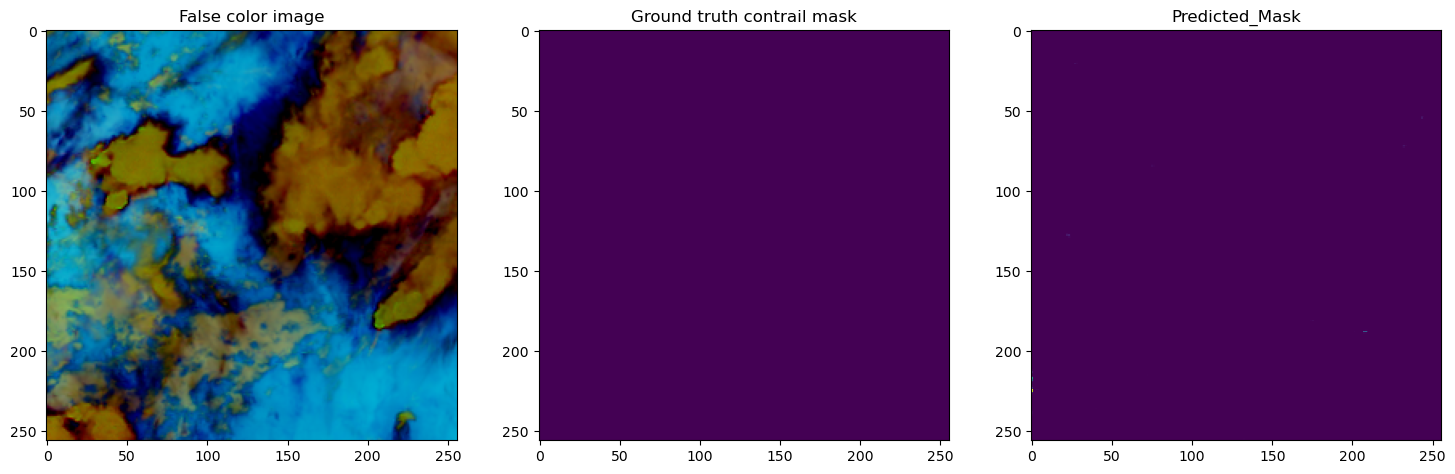

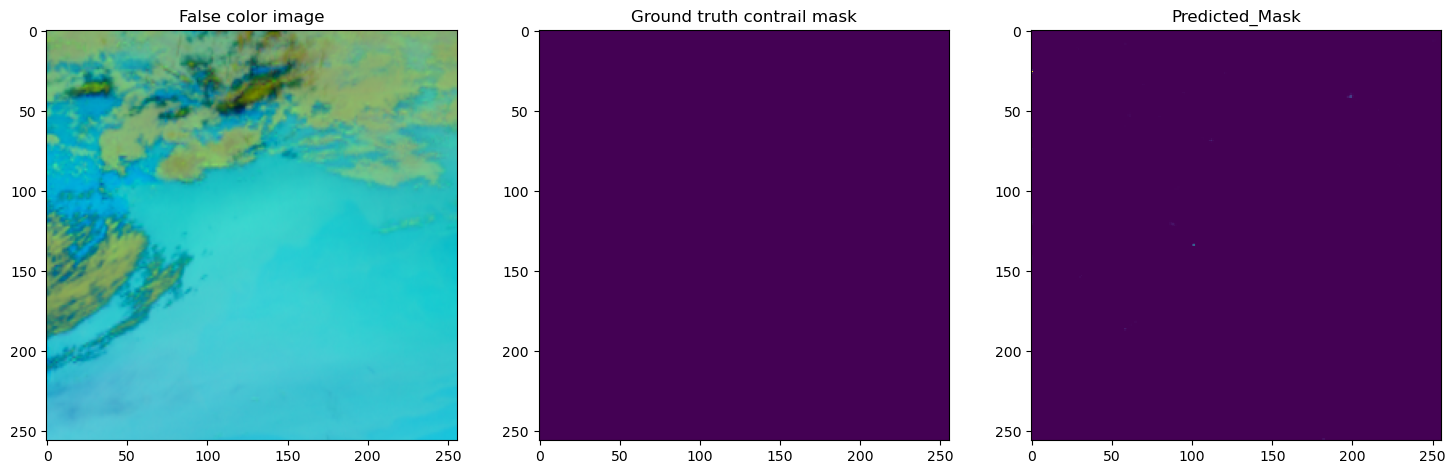

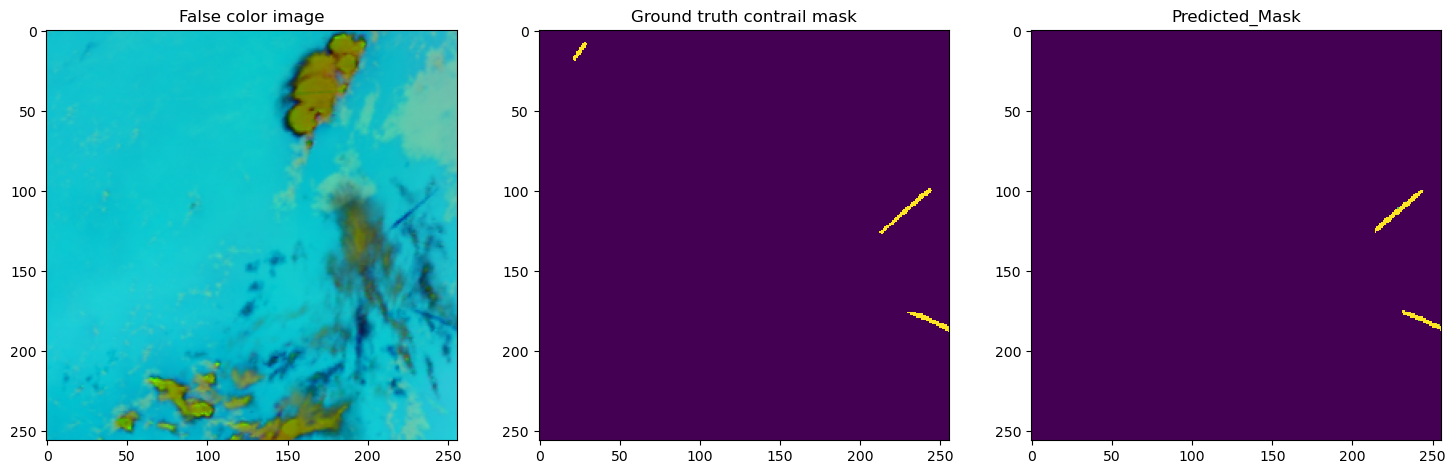

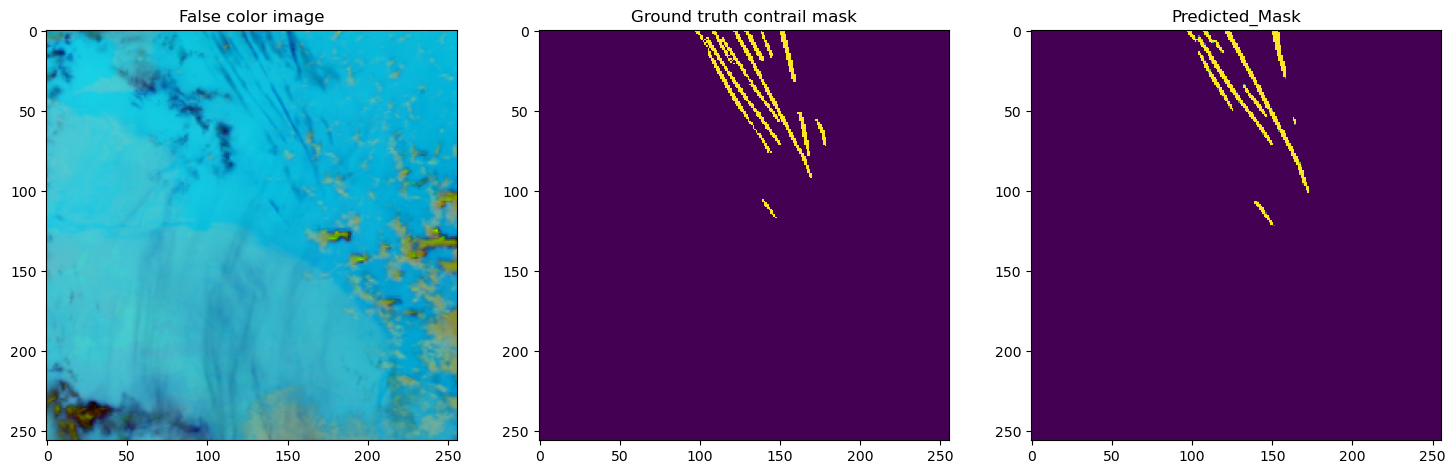

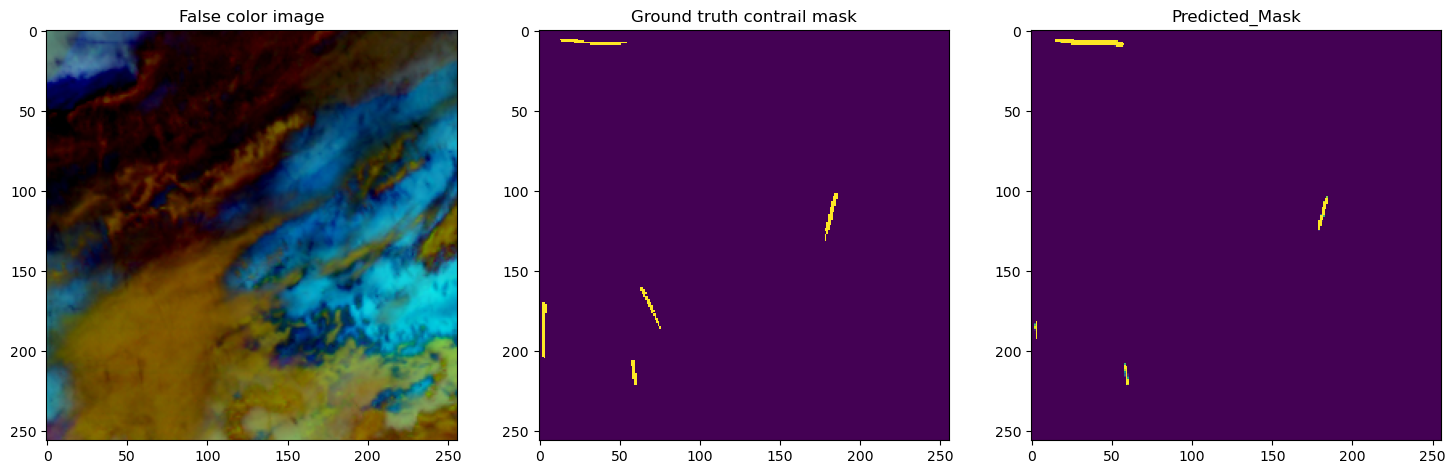

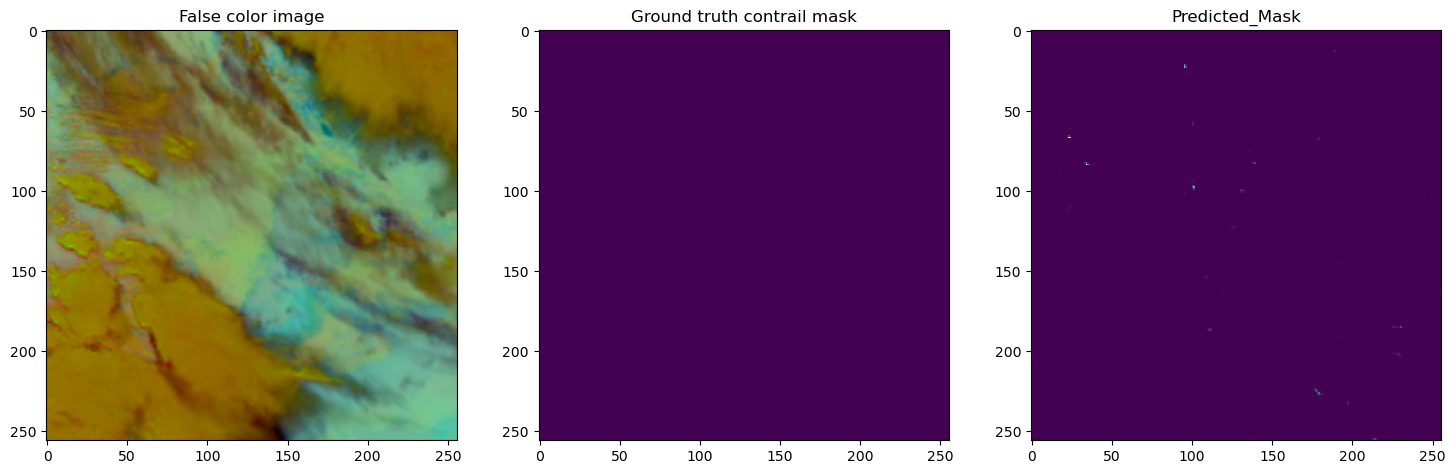

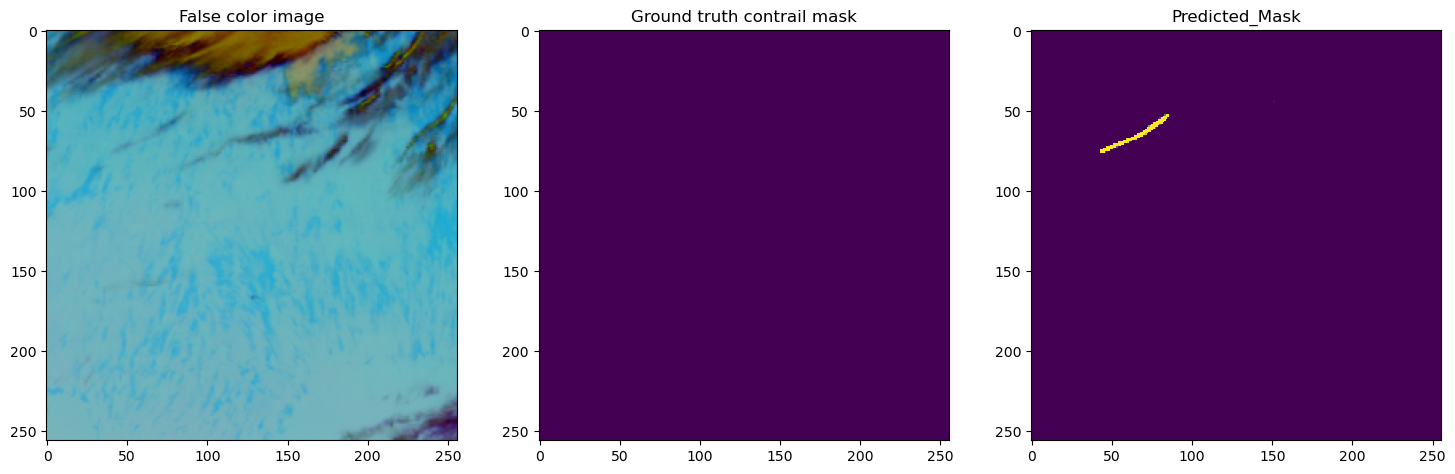

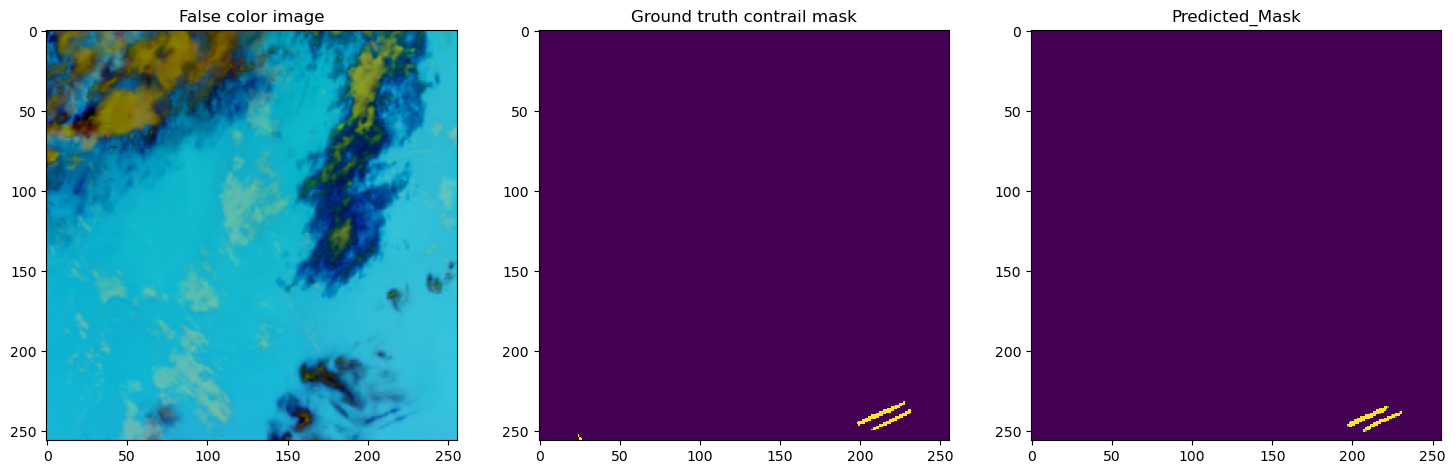

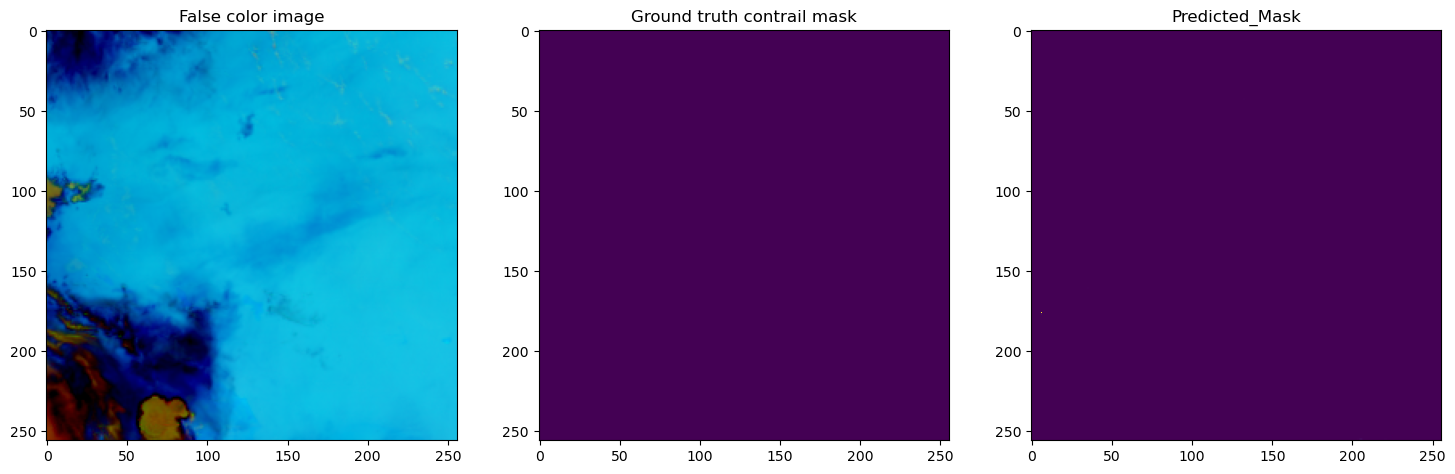

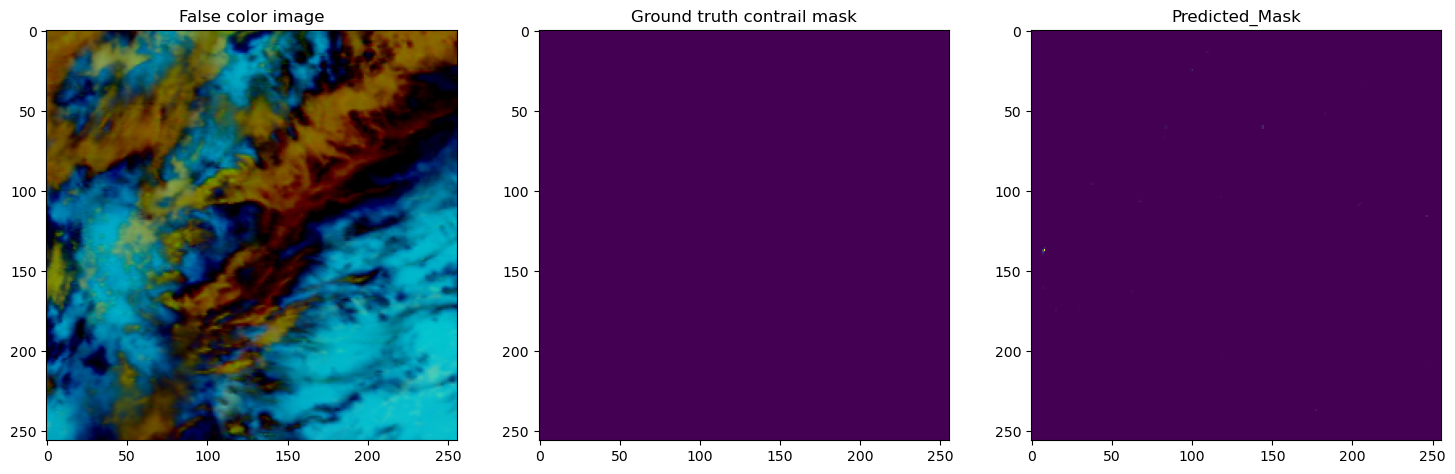

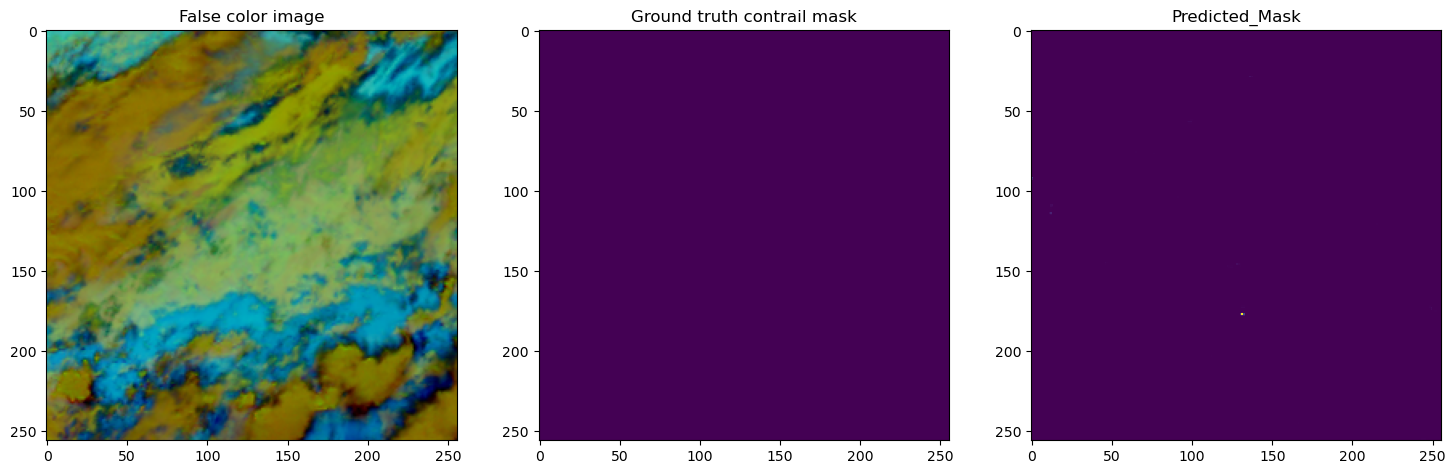

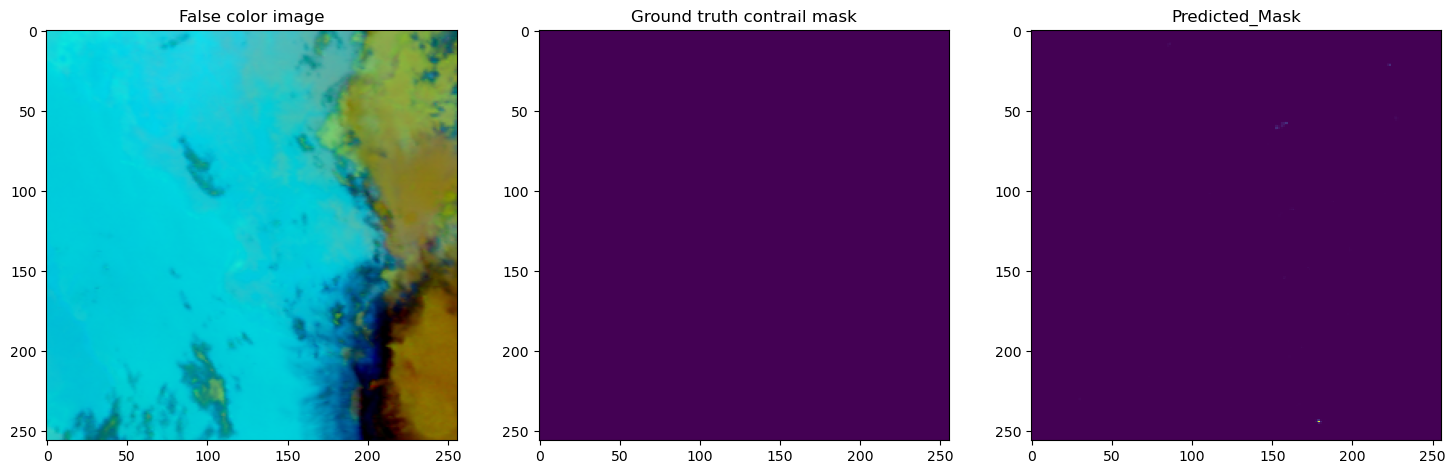

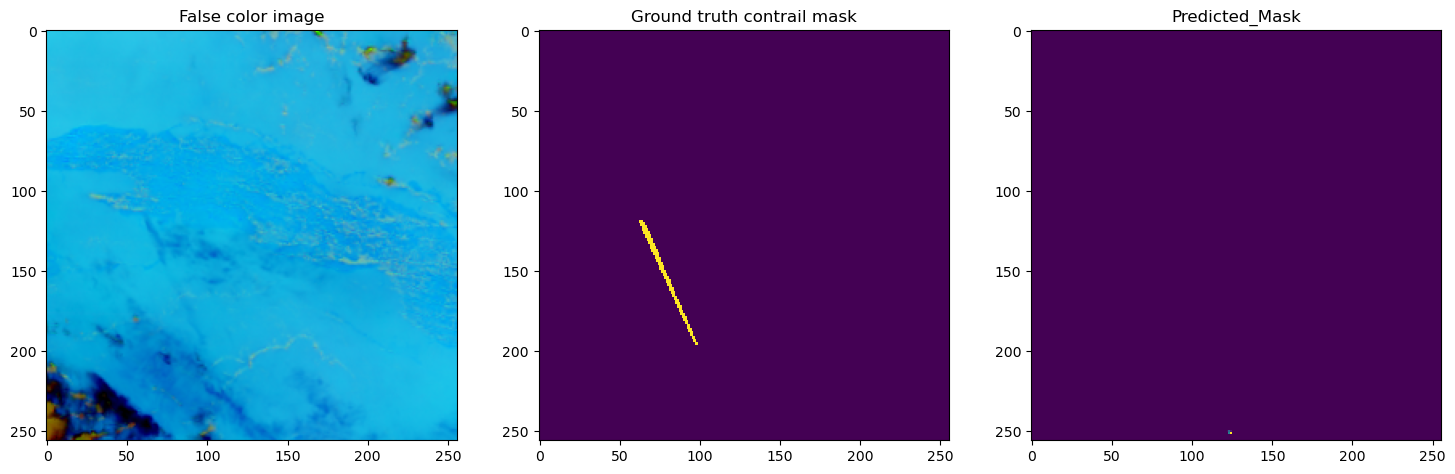

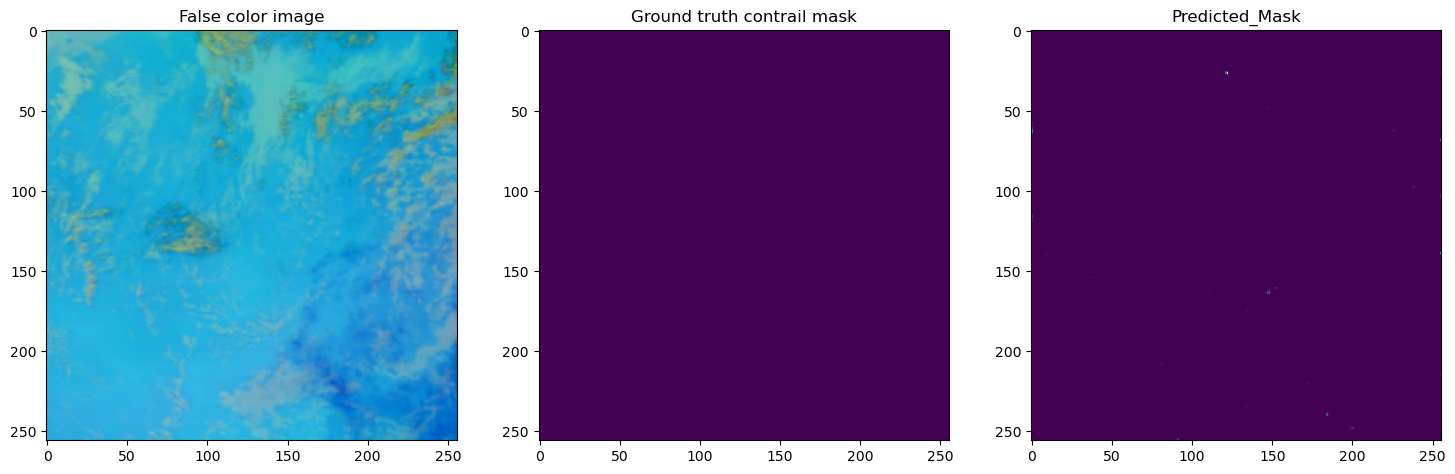

In [13]:
image,mask = next(iter(validation_dataloader))

image,mask = image.to(device), mask.to(device)
pred_mask = model(image)

image = torch.moveaxis(image,1,-1)
mask = torch.moveaxis(mask,1,-1)
pred_mask = torch.moveaxis(pred_mask,1,-1)

image, mask, pred_mask = image.cpu(),mask.cpu(),pred_mask.detach().cpu()

for i in range(CFG.batch_size):
    
    plt.figure(figsize=(18, 6))
    
    ax = plt.subplot(1, 3, 1)
    ax.imshow(image[i])
    ax.set_title('False color image')
    

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask[i], interpolation='none')
    ax.set_title('Ground truth contrail mask')
    
    ax = plt.subplot(1, 3, 3)
    ax.imshow(pred_mask[i], interpolation='none')
    ax.set_title('Predicted_Mask')
        


# Bonus: Vary the threshold for the predictions

In [14]:
bst_dice = 0
thresholds = [0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for threshold in thresholds:
    
    model.train(False)
    bar = tqdm(validation_dataloader)

    tot_dice_avg = 0
    tot_dice_global = 0
    count = 0
    for image, mask in bar:
        
        if CFG.resize:
            image = torch.nn.functional.interpolate(image, 
                                                size=CFG.resize_value,
                                                mode='bilinear'
                                               )
        image,mask = image.to(device), mask.to(device)
        pred_mask = model(image)
        
        
        pred_mask[pred_mask >= threshold] = 1
        pred_mask[pred_mask<threshold]=0
        
        if CFG.resize:
            pred_mask = torch.nn.functional.interpolate(pred_mask, 
                                                size=256,
                                                mode='bilinear'
                                               )
        
        tot_dice_avg += dice_avg(pred_mask, mask).item()
        tot_dice_global+=dice_global(pred_mask,mask).item()
        count += 1
        bar.set_postfix(ValidDiceAvg=f'{tot_dice_avg/count:.4f}',
                        ValidDiceGlobal = f'{tot_dice_global/count:.4f}')
        
 
    if tot_dice_global/count > bst_dice:
        bst_dice = tot_dice_global/count
        print(f"new best global dice: {bst_dice} for threshold: {threshold}") 

  0%|          | 0/116 [00:00<?, ?it/s]

new best global dice: 0.5902440802333448 for threshold: 0.01


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]